In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [ ]:
dataset = load_dataset("ag_news")
df_test = pd.DataFrame(dataset['test'])
df_train = pd.DataFrame(dataset['train'])
df_train = df_train.groupby('label').apply(lambda x: x.sample(n=4000)).reset_index(drop=True)
df_train = pd.concat([df_train, df_test], axis=0)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
df_train # 16000+7600

,text,label
0,Darfur Peace Talks Seek to Break Deadlock (AP)...,0
1,US smooths way in Fallujah for Muslim relief a...,0
2,Toyota Plans to Open Russian Plant (Reuters) R...,0
3,Marchers demand fair Ukraine poll Tens of thou...,0
4,Clashes Slow as Cleric's Grip on Mosque Seems ...,0
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


In [ ]:
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [ ]:
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones
tokenizer.fit_on_texts(list(df_train['text']))
tokenized_texts = tokenizer.texts_to_sequences(df_train['text'])
X = pad_sequences(tokenized_texts, maxlen=100)

In [ ]:
y = pd.get_dummies(df_train["label"]).values

In [ ]:
X

array([[    0,     0,     0, ...,     1,   426,   870],
       [    0,     0,     0, ...,    12,    30,   359],
       [    0,     0,     0, ...,   460,    13,   686],
       ...,
       [    0,     0,     0, ...,  5389,    18,   532],
       [    0,     0,     0, ...,    63,    34, 12157],
       [    0,     0,     0, ..., 14943,     4,  3431]], dtype=int32)

In [ ]:
X.shape

(23600, 100)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state = 42)

In [ ]:
y_train

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk import word_tokenize
data = df_train['text'].map(word_tokenize).values
total_vocabulary = set(word.lower() for tweet in data for word in tweet)

In [ ]:
len(total_vocabulary)

45574

In [ ]:
model = Sequential()
embedding_size = 128
#model.add(Embedding(len(total_vocabulary), embedding_size,trainable=False))
model.add(Embedding(len(total_vocabulary), embedding_size,trainable=True))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(4, activation='softmax'))  

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         5833472   
                                                                 
 lstm (LSTM)                 (None, None, 25)          15400     
                                                                 
 global_max_pooling1d (Globa  (None, 25)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 50)                1300      
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                        

In [ ]:
history =model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
126/126 [==============================] - 25s 140ms/step - loss: 0.9844 - accuracy: 0.6507 - val_loss: 0.4382 - val_accuracy: 0.8644
Epoch 2/10
126/126 [==============================] - 10s 79ms/step - loss: 0.3196 - accuracy: 0.9076 - val_loss: 0.3360 - val_accuracy: 0.8930
Epoch 3/10
126/126 [==============================] - 5s 41ms/step - loss: 0.1755 - accuracy: 0.9535 - val_loss: 0.3739 - val_accuracy: 0.8841
Epoch 4/10
126/126 [==============================] - 5s 36ms/step - loss: 0.1199 - accuracy: 0.9695 - val_loss: 0.4044 - val_accuracy: 0.8863
Epoch 5/10
126/126 [==============================] - 4s 32ms/step - loss: 0.0839 - accuracy: 0.9809 - val_loss: 0.4417 - val_accuracy: 0.8835
Epoch 6/10
126/126 [==============================] - 3s 24ms/step - loss: 0.0627 - accuracy: 0.9855 - val_loss: 0.5032 - val_accuracy: 0.8795
Epoch 7/10
126/126 [==============================] - 3s 21ms/step - loss: 0.0561 - accuracy: 0.9864 - val_loss: 0.5237 - val_accuracy: 0.8

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

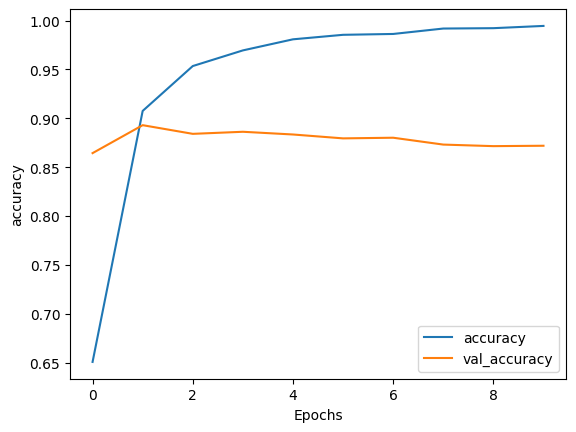

In [ ]:
plot_graphs(history, "accuracy")

In [ ]:
y_proba = model.predict(X_test)
y_pred = np.argmax(y_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

236/236 [==============================] - 1s 3ms/step


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
precision, recall, fscore, support= score(y_true, y_pred)
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 score: {}".format(fscore))
print("Support: {}".format(support))
print("Accuracy score:{}".format(accuracy_score(y_true, y_pred)))

Precision: [0.87804878 0.90515464 0.84008417 0.86356164]
Recall: [0.87249737 0.94459387 0.83832021 0.83386243]
F1 score: [0.87526427 0.9244538  0.83920126 0.84845222]
Support: [1898 1859 1905 1890]
Accuracy score:0.8719544491525424


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_true=y_true, y_pred=y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1898
           1       0.91      0.94      0.92      1859
           2       0.84      0.84      0.84      1905
           3       0.86      0.83      0.85      1890

    accuracy                           0.87      7552
   macro avg       0.87      0.87      0.87      7552
weighted avg       0.87      0.87      0.87      7552

[[1656   89   94   59]
 [  55 1756   23   25]
 [  96   47 1597  165]
 [  79   48  187 1576]]
